# Pd Adatom self-diffusion using an EAM Potential



## References 
###      [1] AP275 Labs, Boris Kozinsky (Harvard U), https://github.com/bkoz37/labutil
    
Simon Batzner

## Params:

You will need to set the same environment variables as used in the labs: 

    1. LAMMPS_COMMAND=<path-to-lammps-executable>
    2. LAMMPS_POTENTIALS=<path-to-dir-with-lammps-potential files>

### Note: 
    
    Bulk should be relaxed first to find lattice parameter with given potential, then cut off for surface and top 
    layers should be relaxed; this is still missing. 

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from src.plugins.lammps import *
from src.objects import *
from ase.build import *
from ase.io import write
from ase.spacegroup import crystal

In [141]:
workdir = os.path.join(os.environ['ML_HOME'], 'EAM')
write_cif = False
write_qe = False

## Templates for MD run and convergence of params

In [20]:
input_template_conv = """
# ---------- 1. Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT

# ---------- 2. Specify interatomic potential ---------------------
pair_style eam
pair_coeff * * $POTENTIAL

# ---------- 3. Run single point calculation  ---------------------
thermo_style custom step pe lx ly lz press pxx pyy pzz
run 0

# ---- 4. Define and print useful variables -------------
variable natoms equal "count(all)"
variable totenergy equal "pe"
variable length equal "lx"

print "Total energy (eV) = ${totenergy}"
print "Number of atoms = ${natoms}"
print "Lattice constant (Angstoms) = ${length}"
        """

In [21]:
input_template_run = """
# ---------- Initialize simulation ---------------------
units metal
atom_style atomic
dimension  3
boundary   p p p
read_data $DATAINPUT
pair_style eam
pair_coeff * * $POTENTIAL
velocity  all create $TEMPERATURE 87287 dist gaussian

# ---------- Describe computed properties------------------
compute msdall all msd
thermo_style custom step pe ke etotal temp press density c_msdall[4]
thermo $TOUTPUT

# ---------- Specify ensemble  ---------------------
fix  1 all nve
#fix  1 all nvt temp $TEMPERATURE $TEMPERATURE $TDAMP

# --------- Compute RDF ---------------
compute rdfall all rdf 100 1 1
fix 2 all ave/time 1 $RDFFRAME $RDFFRAME c_rdfall[*] file $RDFFILE mode vector

# --------- Run -------------
timestep $TIMESTEP
run $NSTEPS
"""

## Build Structures

In [136]:
def make_bulk(alat, size, el = 'Pd', lattice = 'fcc'):
    """
    Creates the bulk crystal structure using ASE.
    
    :param alat: lattice parameter
    :return: structure object converted from ase
    """
    # create bulk cell
    cell = bulk(el, lattice, a=alat)
    
    # make supercell
    multiplier = numpy.identity(3) * size
    supercell = make_supercell(cell, multiplier)

    # write QE input and cif file
    file_prefix = 'bulk_' + str(width) + '_' + str(depth) + '_' + str(vacuum)
    
    n_atoms = supercellcell.get_number_of_atoms()
    structure = Struc(ase2struc(supercell))

    return structure, n_atoms

In [137]:
def make_bulk_w_vacancy(alat, size, el = 'Pd', lattice = 'fcc'):
    """
    Creates the bulk crystal structure using ASE with a vacancy
    
    :param alat: lattice parameter
    :return: structure object converted from ase
    """
    
    # create bulk cell
    cell = bulk(el, lattice, a=alat)
    
    # make supercell
    multiplier = numpy.identity(3) * size
    supercell = make_supercell(cell, multiplier)
    
    # remove atom to form vacancy
    supercell.pop(supercell.get_number_of_atoms() // 2)

    n_atoms = supercell.get_number_of_atoms()
    structure = Struc(ase2struc(supercell))
    
    return structure, n_atoms

In [138]:
def make_slab(el, alat, width, depth, vacuum):
    """
    Creates the slab crystal structure using ASE.
    
    :param width: width of slab
    :param depth: depth of slab
    :param vacuum: vacuum in Angstrom
    :return: structure object converted from ase
    """
    # create surface slab
    slab = fcc111(el, a=alat, size=(width, width, depth))

    # add adatom - supported special adsorption sites for fcc111: 'ontop', 'bridge', 'fcc' and 'hcp'
    add_adsorbate(slab, el, 1.5, 'ontop')

    # center along z-axis
    slab.center(vacuum=vacuum, axis=2)

    n_atoms = slab.get_number_of_atoms()
    structure = Struc(ase2struc(slab))

    return structure, n_atoms

## Run Things

In [92]:
def compute_energy(el, alat, width, depth, vacuum, template, cnt):
    """
    Make an input template and select potential and structure, and the path where to run
    """
    potpath = os.path.join(os.environ['LAMMPS_POTENTIALS'], el + '_u3.eam')
    potential = ClassicalPotential(path=potpath, ptype='eam', element=[el])
    runpath = Dir(path=os.path.join(workdir, os.path.join('runs', str(cnt))))
    struc, n_atoms = make_slab(el = el, alat=alat, width=width, depth=depth, vacuum=vacuum)
    output_file = lammps_run(struc=struc, runpath=runpath, potential=potential, intemplate=template, inparam={})
    energy, lattice = get_lammps_energy(outfile=output_file)

    # normalize energy
    energy = energy / n_atoms

    return energy, lattice

In [93]:
def converge_slab(el, alat):
    width_arr = np.linspace(1, width_max)
    depth_arr = np.linspace(1, depth_max)
    vacuum_arr = np.linspace(1, vacuum_max)

    e_w_list = []
    e_d_list = []
    e_v_list = []

    # converge width
    cnt = 0
    for width in width_arr:
        e_w_list.append(compute_energy(el = el, alat = alat, width=int(width), depth=int(depth_def), vacuum=int(vacuum_def),
                                       template=input_template_conv, cnt=cnt)[0])
        cnt += 1

    # converge depth
    for depth in depth_arr:
        e_d_list.append(compute_energy(el = el, alat = alat, width=int(width_def), depth=int(depth), vacuum=int(vacuum_def),
                                       template=input_template_conv, cnt=cnt)[0])
        cnt += 1

    # converge vacuum
    for vacuum in vacuum_arr:
        e_v_list.append(compute_energy(el = el, alat = alat, width=int(width_def), depth=int(depth_def), vacuum=int(vacuum),
                                       template=input_template_conv, cnt=cnt)[0])
        cnt += 1

    # convergence plots
    plt.figure(figsize = (12, 10))
    plt.subplot(311)
    plt.plot(width_arr, e_w_list)
    plt.title('E(width)')
    plt.subplot(312)
    plt.plot(depth_arr, e_d_list)
    plt.title('E(depth)')
    plt.subplot(313)
    plt.plot(vacuum_arr, e_v_list)
    plt.title('E(vacuum)')
    plt.show()

    return

In [134]:
def compute_dynamics(struc_type, el, alat, timestep, nsteps, temperature, width, depth, vacuum):
    """
    Make an input template and select potential and structure, and input parameters.
    Return a pair of output file and RDF file written to the runpath directory.
    """
    potpath = os.path.join(os.environ['LAMMPS_POTENTIALS'], el + '_u3.eam')
    potential = ClassicalPotential(path=potpath, ptype='eam', element=[el])
    runpath = Dir(path=workdir)
    
    if struc_type=='slab': 
        struc, n_atoms = make_slab(el=el, alat=alat, width=width, depth=depth, vacuum=vacuum)
    elif struc_type=='bulk_vacancy': 
        print("Bulk vacancy")
        struc, n_atoms = make_bulk_w_vacancy(el=el, alat=alat, size=3, lattice='fcc')
        
    inparam = {
        'TEMPERATURE': temperature,
        'NSTEPS': nsteps,
        'TIMESTEP': timestep,
        'TOUTPUT': 100,  # how often to write thermo output
        'TDAMP': 50 * timestep,  # thermostat damping time scale
        'RDFFRAME': int(nsteps / 4),  # frames for radial distribution function
    }

    outfile = lammps_run(struc=struc, runpath=runpath, potential=potential,
                         intemplate=input_template_run, inparam=inparam)

    output = parse_lammps_thermo(outfile=outfile)
    print(output)
    rdffile = get_rdf(runpath=runpath)
    rdfs = parse_lammps_rdf(rdffile=rdffile)

    return output, rdfs

In [123]:
def md_run(el, alat, nsteps, temperature, width, depth, vacuum, struc_type):
    """ Run MD, plot results """

    # run md
    output, rdfs = compute_dynamics(struc_type=struc_type, el=el, alat=alat, timestep=0.001, nsteps=nsteps, 
                                    temperature=temperature, width=width, depth=depth, vacuum=vacuum)

    # collect results
    [simtime, pe, ke, energy, temp, press, dens, msd] = output

    ## ------- plot mean square displacement
    plt.figure(figsize = (12, 10))
    plt.plot(simtime, msd)
    plt.title('MSD vs. simtime')
    plt.savefig('msd.png')
    plt.show()

#     ## ------- plot radial distribution functions
#     for rdf in rdfs:
#         plt.plot(rdf[0], rdf[1])

#     plt.savefig('rdf.png')
#     plt.show()

## Converge

In [124]:
el = 'Pd'
alat = 4.5

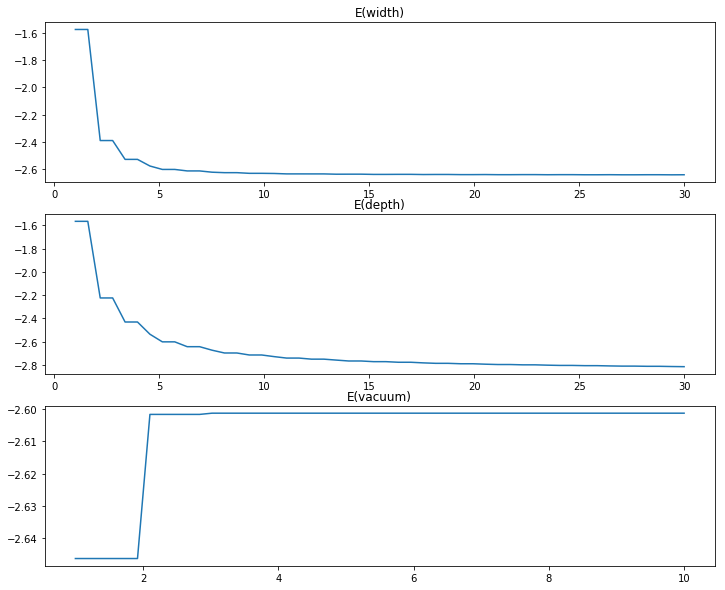

In [107]:
# defaults used for converging other params
width_def = 5
depth_def = 5
vacuum_def = 10

# maxima for convergence
width_max = 30
depth_max = 30
vacuum_max = 10

converge_slab(el=el, alat = alat)

## Run MD for surface adatom

In [142]:
el = 'Pd'
alat = 4.5 # find this from relaxation first

width = 30
depth = 30
vacuum = 10
nsteps = 10000
temperature = 900

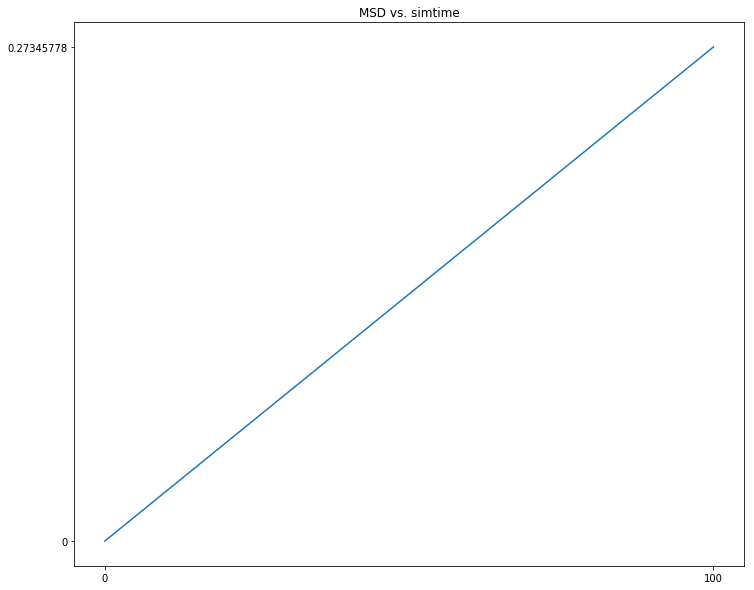

In [127]:
md_run(el, alat, nsteps, temperature, width, depth, vacuum, struc_type='slab')

## Run MD for bulk vacancy

In [129]:
el = 'Pd'
alat = 4.5 # find this from relaxation first
nsteps = 100
temperature = 900
struc_type = 'bulk_vacancy'

In [135]:
md_run(el, alat, nsteps, temperature, width, depth, vacuum, struc_type='bulk_vacancy')

Bulk vacancy
N_atoms before vacancy: 27
N_atoms after vacancy: 26
[]


ValueError: not enough values to unpack (expected 8, got 0)